# 🔄 ETL Pipeline för resenorden_data

---
## 📦 DEL 1: EXTRACT

### Imports och inläsning

In [73]:
import pandas as pd
import numpy as np
import sqlite3

df = pd.read_csv("resenorden_data.csv")

---
## 🔍 Utforska datan

En initial utforskning (EDA) för att förstå datan

In [74]:
df.shape
print(df.shape[0], "rader", ",", df.shape[1], "klumner")

1915 rader , 18 klumner


In [75]:
df.info()

#Datum lagrade som strängar
#Saknade värden (land, valuta, bokningskanal, recensioner)
#Inkonsistenta texter (t.ex. “Genomförd”, “klar”)
#Saknade recensioner & betyg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915 entries, 0 to 1914
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bokning_id       1915 non-null   object 
 1   bokningsdatum    1915 non-null   object 
 2   kund_id          1915 non-null   object 
 3   destination      1915 non-null   object 
 4   land             1786 non-null   object 
 5   avresedatum      1915 non-null   object 
 6   hemresedatum     1915 non-null   object 
 7   antal_resenärer  1915 non-null   int64  
 8   pakettyp         1915 non-null   object 
 9   pris             1915 non-null   float64
 10  valuta           1878 non-null   object 
 11  hotell           1840 non-null   object 
 12  bokningskanal    1802 non-null   object 
 13  status           1915 non-null   object 
 14  avbokningsdatum  155 non-null    object 
 15  recension_text   681 non-null    object 
 16  recensionsdatum  681 non-null    object 
 17  betyg         

In [76]:
df.isna().sum()

bokning_id            0
bokningsdatum         0
kund_id               0
destination           0
land                129
avresedatum           0
hemresedatum          0
antal_resenärer       0
pakettyp              0
pris                  0
valuta               37
hotell               75
bokningskanal       113
status                0
avbokningsdatum    1760
recension_text     1234
recensionsdatum    1234
betyg              1234
dtype: int64

In [77]:
df.head()

,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,valuta,hotell,bokningskanal,status,avbokningsdatum,recension_text,recensionsdatum,betyg
0,RES-2024-00001,2024-01-08,KUND-05456,Köpenhamn,Danmark,2024-01-13,2024-01-15,2,Weekend-paket,8046.10,SEK,Comfort Hotel Vesterbro,App,Genomförd,NaN,"Inget speciellt att rapportera, det fungerade.",2024-01-30,3.0
1,RES-2024-00002,2024-01-26,KUND-05456,Rovaniemi,Finland,2024-03-06,2024-03-11,2,All inclusive,34924.80,SEK,Scandic Rovaniemi,Telefon,Klar,NaN,All inclusive var värt pengarna. Inga bekymmer.,2024-04-01,4.0
2,RES-2024-00003,2024-01-13,KUND-05177,Rovaniemi,Finland,2024-02-09,2024-02-14,2,Halvpension,26757.60,SEK,Scandic Rovaniemi,App,Genomförd,NaN,Smidigt att boka och allt fungerade perfekt.,2024-02-19,4.0
3,RES-2024-00004,2024-01-12,KUND-06857,Tromsø,Norge,2024-02-17,2024-02-20,2,Halvpension,2349.80,EUR,Clarion Hotel The Edge,Webb,Genomförd,NaN,Såg norrsken tre av fyra kvällar. Fantastiskt!,2024-03-03,5.0
4,RES-2024-00005,2024-01-13,KUND-08178,Köpenhamn,Danmark,2024-01-18,2024-01-20,2,Weekend-paket,5289.74,DKK,Comfort Hotel Vesterbro,App,Genomförd,NaN,NaN,NaN,NaN


---
## 📝 Min transformationsplan

1. **Bokningsdatum:** nuvarande värde är en sträng → ska konverteras till datetime.
2. **avresedatum:** nuvarande värde är en sträng → ska konverteras till datetime.
3. **hemresedatum:** nuvarande värde är en sträng → ska konverteras till datetime.
4. **avbokningsdatum:** nuvarande värde är en sträng → ska konverteras till datetime.
5. **recensionsdatum:** nuvarande värde är en sträng → ska konverteras till datetime.
6. **destination:** hög variation i stavning → ska normaliserars.
7. **land:** många Saknade länder → ersätter hela kolumnen baserat på destination.
8. **pakettyp:** hög variation i stavning → alla varianter samlas till en standard per pakettyp.
9. **pris:** säkerställer att pris är numeriskt och avrundat till två decimaler.
10. **valuta:** många saknade valutor → fyller saknade värden baserat på land.
11. **hotell:** många saknade värden → ersätter NaN i kolumnen med "saknas".
12. **bokningskanal:** olika variation i stavning → normaliserar bokningskanal och ersätter NaN med "saknas"
13. **satus:** olika variation i stavning → ska normaliseraras




---
# 🛠️ TRANSFORM-FUNKTIONER

## Funktion 1: Städa datumkolumner

Datumkolumner konverteras till datetime

In [78]:
def clean_datum(df):
    df_clean = df.copy()
    date_columns = ["bokningsdatum", "avresedatum", "hemresedatum", "avbokningsdatum", "recensionsdatum"]
    
    for col in date_columns:
        df_clean[col] = pd.to_datetime(df_clean[col], dayfirst=True, format="mixed", errors="coerce")
    
    return df_clean

In [184]:
df_clean = clean_datum(df_clean)

df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915 entries, 0 to 1914
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   bokning_id       1915 non-null   object        
 1   bokningsdatum    1908 non-null   datetime64[ns]
 2   kund_id          1915 non-null   object        
 3   destination      1915 non-null   object        
 4   land             1786 non-null   object        
 5   avresedatum      1907 non-null   datetime64[ns]
 6   hemresedatum     1908 non-null   datetime64[ns]
 7   antal_resenärer  1915 non-null   int64         
 8   pakettyp         1915 non-null   object        
 9   pris             1915 non-null   float64       
 10  valuta           1878 non-null   object        
 11  hotell           1915 non-null   object        
 12  bokningskanal    1802 non-null   object        
 13  status           1915 non-null   object        
 14  avbokningsdatum  155 non-null    datetim

---
## Funktion 2: Städa destination

Normaliserar destination till: köpenhamn, rovaniemi, tromso, oslo, helsingfors, reykjavik, bergen eller trondheim

In [156]:
def clean_destination(df):
    df_clean = df.copy()

    df_clean["destination"] = (
        df_clean["destination"]
        .str.lower()
        .str.strip()
        .replace({
            # Köpenhamn
            "köpenhamn": "köpenhamn",
            "københavn": "köpenhamn",
            "kopenhamn": "köpenhamn",
            "copenhagen": "köpenhamn",
            "cph": "köpenhamn",
            "Köpenhamn": "köpenhamn",

            # Rovaniemi
            "rovaniemi": "rovaniemi",
            "rovaniem": "rovaniemi",
            "Rovaniemi": "rovaniemi",

            # Tromsø
            "tromsø": "tromso",
            "tromso": "tromso",
            "tromsö": "tromso",
            "Tromso": "tromso",
            "Tromsø": "tromso",
            "TROMSØ": "tromso",
            "Tromso": "tromso",

            # Oslo
            "oslo": "oslo",
            "oslö": "oslo",

            # Helsingfors
            "helsingfors": "helsingfors",
            "helsinki": "helsingfors",
            "hfors": "helsingfors",
            "Helsingfors": "helsingfors",
            
            # Reykjavik
            "reykjavik": "reykjavik",
            "reykjavík": "reykjavik",
            "reykavik": "reykjavik",
            "rey": "reykjavik",
            "Reykjavik": "reykjavik",

            # Bergen
            "bergen": "bergen",

            # Trondheim
            "trondheim": "trondheim",
            "tronheim": "trondheim",
        })
    )

    return df_clean

In [187]:
df_clean = clean_destination(df_clean)

df_clean["destination"].unique()

array(['köpenhamn', 'rovaniemi', 'tromso', 'oslo', 'helsingfors',
       'reykjavik', 'bergen', 'trondheim'], dtype=object)

---
## Funktion 3: städa land

Ersätter hela land-kolumnen baserat på destination


In [175]:
def clean_land(df):
    df_clean = df.copy()

    # Normalisera befintliga värden (utan att förstöra formatet)
    df_clean["land"] = (
        df_clean["land"]
        .str.strip()
        .str.lower()
    )

    # Mapping destination -> country (lowercase)
    destination_to_country = {
        "köpenhamn": "Danmark",
        "oslo": "Norge",
        "bergen": "Norge",
        "trondheim": "Norge",
        "tromso": "Norge",
        "rovaniemi": "Finland",
        "helsingfors": "Finland",
        "reykjavik": "Island",
    }

    # Fyll NaN baserat på destination
    df_clean["land"] = df_clean["land"].fillna(
        df_clean["destination"].map(destination_to_country)
    )

    # Sätt slutligt standardformat (samma för alla)
    df_clean["land"] = df_clean["land"].replace({
        "danmark": "Danmark",
        "norge": "Norge",
        "finland": "Finland",
        "island": "Island",
    })

    return df_clean


In [188]:
df_clean = clean_land(df_clean)

df_clean["land"].unique()


array(['Danmark', 'Finland', 'Norge', 'Island'], dtype=object)

---
## Funktion 4: Städa pakettyp
alla varianter samlas till en standard per pakettyp: Weekend, All inclusive, Halvpension eller Endast boende 

In [190]:
def clean_pakettyp(df):
    df_clean = df.copy()

    df_clean["pakettyp"] = (
        df_clean["pakettyp"]
        .str.lower()
        .str.strip()
        .replace({
            # Weekend
            "weekend-paket": "weekend",
            "weekend paket": "weekend",
            "weekend": "weekend",
            "helgresa": "weekend",

            # All inclusive
            "all inclusive": "all inclusive",
            "all-inclusive": "all inclusive",
            "all inkl": "all inclusive",
            "ai": "all inclusive",
            "all inclusive ": "all inclusive",

            # Halvpension
            "halvpension": "halvpension",
            "half board": "halvpension",
            "hp": "halvpension",

            # Endast boende
            "endast boende": "endast boende",
            "room only": "endast boende",
            "ro": "endast boende",
            "bara hotell": "endast boende",
        })
    )

    return df_clean

In [191]:
df_clean = clean_pakettyp(df_clean)

df_clean["pakettyp"].value_counts()

pakettyp
weekend          624
halvpension      481
all inclusive    409
endast boende    401
Name: count, dtype: int64

---
## Funktion 5: Fixa pris

avrundar till 2 decimaler

behåller NaN


In [169]:
def clean_pris(df):
    df_clean = df.copy()

    df_clean["pris"] = (
        df_clean["pris"]
        .astype(float)
        .round(2)
    )

    return df_clean

In [193]:
df_clean = clean_pris(df_clean)

df_clean["pris"].head()

0     8046.10
1    34924.80
2    26757.60
3     2349.80
4     5289.74
Name: pris, dtype: float64

---
## Funktion 6: Fixa valuta

Fyller saknade valutor baserat på land


In [177]:
def clean_valuta(df):
    df_clean = df.copy()

    country_to_currency = {
        "danmark": "DKK",
        "norge": "NOK",
        "finland": "EUR",
        "island": "ISK",
    }

    # Gör land matchbart mot nycklarna (lowercase) + gör tomma strängar till NaN
    land_norm = (
        df_clean["land"]
        .astype("string")
        .str.strip()
        .str.lower()
        .replace(r"^\s*$", np.nan, regex=True)
    )

    # Fyll NaN i valuta baserat på land
    df_clean["valuta"] = df_clean["valuta"].fillna(land_norm.map(country_to_currency))

    return df_clean


In [194]:
df_clean = clean_valuta(df_clean)

df_clean["valuta"].unique()

array(['SEK', 'EUR', 'DKK', 'NOK', 'ISK'], dtype=object)

---
## Funktion 7: Fixa hotell

Ersätter NaN i hotell-kolumnen med "saknas".

In [196]:
def clean_hotell(df):
    df_clean = df.copy()

    df_clean["hotell"] = df_clean["hotell"].fillna("saknas")
    return df_clean

In [197]:
df_clean = clean_hotell(df_clean)

df_clean["hotell"].value_counts()

hotell
Hotel Scandic Copenhagen       239
Comfort Hotel Vesterbro        234
Hotel D'Angleterre             229
Smarthotel Tromsø              104
Clarion Hotel The Edge          90
Hotel Continental               88
Comfort Hotel Grand Central     85
Thon Hotel Opera                80
Arctic TreeHouse Hotel          78
saknas                          75
CenterHotel Midgardur           72
Scandic Rovaniemi               71
Hotel Borg                      61
Bus Hostel Reykjavik            56
Hotel Kämp                      56
Original Sokos Hotel            53
Budget Hotel Bergen             53
Omena Hotel                     51
Hotel Norge                     50
Comfort Hotel Trondheim         48
Britannia Hotel                 42
Name: count, dtype: int64

---
## Funktion 8: städa bokningskanal

Normaliserar bokningskanal och ersätter NaN med "saknas"



In [25]:
def clean_bokningskanal(df):
    df_clean = df.copy()

    df_clean["bokningskanal"] = (
        df_clean["bokningskanal"]
        .str.lower()
        .str.strip()
        .replace({
            # App
            "app": "app",
            "mobile": "app",
            "mobil": "app",

            # Telefon
            "telefon": "telefon",
            "tel": "telefon",
            "ring": "telefon",
            "phone": "telefon",

            # Webb
            "webb": "webb",
            "web": "webb",
            "website": "webb",
            "internet": "webb",
            "online": "webb",
        })
        .fillna("saknas")
    )

    return df_clean

In [198]:
df_clean = clean_bokningskanal(df_clean)

df_clean["bokningskanal"].unique()


array(['app', 'telefon', 'webb', 'saknas'], dtype=object)

---
## Funktion 9: städa status

Normaliserar status till: genomförd, avbokad, bekräftad eller bokad


In [27]:
def clean_status(df):
    df_clean = df.copy()

    df_clean["status"] = (
        df_clean["status"]
        .str.lower()
        .str.strip()
        .replace({
            # Genomförd
            "genomförd": "genomförd",
            "klar": "genomförd",
            "completed": "genomförd",

            # Avbokad
            "avbokad": "avbokad",
            "cancelled": "avbokad",
            "struken": "avbokad",

            # Bekräftad
            "bekräftad": "bekräftad",
            "confirmed": "bekräftad",
            "ok": "bekräftad",

            # Bokad
            "bokad": "bokad",
        })
    )

    return df_clean


In [199]:
df_clean = clean_status(df_clean)

df_clean["status"].unique()

array(['genomförd', 'avbokad', 'bekräftad', 'bokad'], dtype=object)

---
# 🔗 Sätta ihop pipeline-funktionen


In [200]:
def transform_resenorden(df):
    df_clean = df.copy()

    df_clean = clean_datum(df_clean)
    df_clean = clean_destination(df_clean)
    df_clean = clean_land(df_clean)
    df_clean = clean_pakettyp(df_clean)
    df_clean = clean_pris(df_clean)
    df_clean = clean_valuta(df_clean)
    df_clean = clean_hotell(df_clean)
    df_clean = clean_bokningskanal(df_clean)
    df_clean = clean_status(df_clean)
    
    return df_clean


In [201]:
clean_complete = transform_resenorden(df)

print(f"Rader: {len(df)} -> {len(clean_complete)}")
print("\nDatatyper:")
print(clean_complete.dtypes)
print("\nNaN per kolumn:")
print(clean_complete.isna().sum())


Rader: 1915 -> 1915

Datatyper:
bokning_id                 object
bokningsdatum      datetime64[ns]
kund_id                    object
destination                object
land                       object
avresedatum        datetime64[ns]
hemresedatum       datetime64[ns]
antal_resenärer             int64
pakettyp                   object
pris                      float64
valuta                     object
hotell                     object
bokningskanal              object
status                     object
avbokningsdatum    datetime64[ns]
recension_text             object
recensionsdatum    datetime64[ns]
betyg                     float64
dtype: object

NaN per kolumn:
bokning_id            0
bokningsdatum         7
kund_id               0
destination           0
land                  0
avresedatum           8
hemresedatum          7
antal_resenärer       0
pakettyp              0
pris                  0
valuta                0
hotell                0
bokningskanal         0
status       

---

## ✅ Genomförd transformationsplan

**Samtliga planerade transformationer har nu genomförts enligt planen.**

Datumfält för bokning, resa, avbokning och recension har konverterats från strängar till korrekt datetime-format.
Destinationer, pakettyper, bokningskanaler och statusfält har normaliserats för att minska variation i stavning och säkerställa konsekventa värden.

Kolumnen land har kompletterats och standardiserats baserat på destination, och saknade valutavärden har fyllts i med hjälp av landinformation. Prisfältet har rensats, säkerställts som numeriskt och avrundats till två decimaler. Saknade värden i hotell- och bokningskanalkolumner har ersatts med värdet "saknas".

Datasetet är nu rensat, standardiserat och redo för vidare analys.

---
# 🛠️ Feature Engineering 

--- 
## Skapa kopia

Skapar en kopia av DataFrame för att arbeta vidare, så att originalet förblir oförändrat.

In [202]:
df_feat = clean_complete.copy()

df_feat.head()

,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,valuta,hotell,bokningskanal,status,avbokningsdatum,recension_text,recensionsdatum,betyg
0,RES-2024-00001,2024-01-08,KUND-05456,köpenhamn,Danmark,2024-01-13,2024-01-15,2,weekend,8046.10,SEK,Comfort Hotel Vesterbro,app,genomförd,NaT,"Inget speciellt att rapportera, det fungerade.",2024-01-30,3.0
1,RES-2024-00002,2024-01-26,KUND-05456,rovaniemi,Finland,2024-03-06,2024-03-11,2,all inclusive,34924.80,SEK,Scandic Rovaniemi,telefon,genomförd,NaT,All inclusive var värt pengarna. Inga bekymmer.,2024-04-01,4.0
2,RES-2024-00003,2024-01-13,KUND-05177,rovaniemi,Finland,2024-02-09,2024-02-14,2,halvpension,26757.60,SEK,Scandic Rovaniemi,app,genomförd,NaT,Smidigt att boka och allt fungerade perfekt.,2024-02-19,4.0
3,RES-2024-00004,2024-01-12,KUND-06857,tromso,Norge,2024-02-17,2024-02-20,2,halvpension,2349.80,EUR,Clarion Hotel The Edge,webb,genomförd,NaT,Såg norrsken tre av fyra kvällar. Fantastiskt!,2024-03-03,5.0
4,RES-2024-00005,2024-01-13,KUND-08178,köpenhamn,Danmark,2024-01-18,2024-01-20,2,weekend,5289.74,DKK,Comfort Hotel Vesterbro,app,genomförd,NaT,NaN,NaT,NaN


---
## Bokningsmånad

Den kan anvädas till säsongsmönster (vilka månader bokas mest).

In [203]:
df_feat["boknings_manad"] = df_feat["bokningsdatum"].dt.month

df_feat.head()

,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,valuta,hotell,bokningskanal,status,avbokningsdatum,recension_text,recensionsdatum,betyg,boknings_manad
0,RES-2024-00001,2024-01-08,KUND-05456,köpenhamn,Danmark,2024-01-13,2024-01-15,2,weekend,8046.10,SEK,Comfort Hotel Vesterbro,app,genomförd,NaT,"Inget speciellt att rapportera, det fungerade.",2024-01-30,3.0,1.0
1,RES-2024-00002,2024-01-26,KUND-05456,rovaniemi,Finland,2024-03-06,2024-03-11,2,all inclusive,34924.80,SEK,Scandic Rovaniemi,telefon,genomförd,NaT,All inclusive var värt pengarna. Inga bekymmer.,2024-04-01,4.0,1.0
2,RES-2024-00003,2024-01-13,KUND-05177,rovaniemi,Finland,2024-02-09,2024-02-14,2,halvpension,26757.60,SEK,Scandic Rovaniemi,app,genomförd,NaT,Smidigt att boka och allt fungerade perfekt.,2024-02-19,4.0,1.0
3,RES-2024-00004,2024-01-12,KUND-06857,tromso,Norge,2024-02-17,2024-02-20,2,halvpension,2349.80,EUR,Clarion Hotel The Edge,webb,genomförd,NaT,Såg norrsken tre av fyra kvällar. Fantastiskt!,2024-03-03,5.0,1.0
4,RES-2024-00005,2024-01-13,KUND-08178,köpenhamn,Danmark,2024-01-18,2024-01-20,2,weekend,5289.74,DKK,Comfort Hotel Vesterbro,app,genomförd,NaT,NaN,NaT,NaN,1.0


---
## Bokningsveckodag (0–6)

Man kan analysera bokningsbeteende per veckodag.

In [204]:
df_feat["boknings_veckodag"] = df_feat["bokningsdatum"].dt.dayofweek  # 0=mån ... 6=sön

df_feat.head()

,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,valuta,hotell,bokningskanal,status,avbokningsdatum,recension_text,recensionsdatum,betyg,boknings_manad,boknings_veckodag
0,RES-2024-00001,2024-01-08,KUND-05456,köpenhamn,Danmark,2024-01-13,2024-01-15,2,weekend,8046.10,SEK,Comfort Hotel Vesterbro,app,genomförd,NaT,"Inget speciellt att rapportera, det fungerade.",2024-01-30,3.0,1.0,0.0
1,RES-2024-00002,2024-01-26,KUND-05456,rovaniemi,Finland,2024-03-06,2024-03-11,2,all inclusive,34924.80,SEK,Scandic Rovaniemi,telefon,genomförd,NaT,All inclusive var värt pengarna. Inga bekymmer.,2024-04-01,4.0,1.0,4.0
2,RES-2024-00003,2024-01-13,KUND-05177,rovaniemi,Finland,2024-02-09,2024-02-14,2,halvpension,26757.60,SEK,Scandic Rovaniemi,app,genomförd,NaT,Smidigt att boka och allt fungerade perfekt.,2024-02-19,4.0,1.0,5.0
3,RES-2024-00004,2024-01-12,KUND-06857,tromso,Norge,2024-02-17,2024-02-20,2,halvpension,2349.80,EUR,Clarion Hotel The Edge,webb,genomförd,NaT,Såg norrsken tre av fyra kvällar. Fantastiskt!,2024-03-03,5.0,1.0,4.0
4,RES-2024-00005,2024-01-13,KUND-08178,köpenhamn,Danmark,2024-01-18,2024-01-20,2,weekend,5289.74,DKK,Comfort Hotel Vesterbro,app,genomförd,NaT,NaN,NaT,NaN,1.0,5.0


---
## Helgbokning (0/1)

Enkel helg vs vardag-analys.

In [215]:
df_feat["ar_helgbokning"] = (df_feat["boknings_veckodag"] >= 5).astype(int) # 1= helg, 0 = vardag

df_feat.head()


,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,...,bokningskanal,status,avbokningsdatum,recension_text,recensionsdatum,betyg,boknings_manad,boknings_veckodag,ar_helgbokning,ledtid_dagar
0,RES-2024-00001,2024-01-08,KUND-05456,köpenhamn,Danmark,2024-01-13,2024-01-15,2,weekend,8046.10,...,app,genomförd,NaT,"Inget speciellt att rapportera, det fungerade.",2024-01-30,3.0,1.0,0.0,0,5.0
1,RES-2024-00002,2024-01-26,KUND-05456,rovaniemi,Finland,2024-03-06,2024-03-11,2,all inclusive,34924.80,...,telefon,genomförd,NaT,All inclusive var värt pengarna. Inga bekymmer.,2024-04-01,4.0,1.0,4.0,0,40.0
2,RES-2024-00003,2024-01-13,KUND-05177,rovaniemi,Finland,2024-02-09,2024-02-14,2,halvpension,26757.60,...,app,genomförd,NaT,Smidigt att boka och allt fungerade perfekt.,2024-02-19,4.0,1.0,5.0,1,27.0
3,RES-2024-00004,2024-01-12,KUND-06857,tromso,Norge,2024-02-17,2024-02-20,2,halvpension,2349.80,...,webb,genomförd,NaT,Såg norrsken tre av fyra kvällar. Fantastiskt!,2024-03-03,5.0,1.0,4.0,0,36.0
4,RES-2024-00005,2024-01-13,KUND-08178,köpenhamn,Danmark,2024-01-18,2024-01-20,2,weekend,5289.74,...,app,genomförd,NaT,NaN,NaT,NaN,1.0,5.0,1,5.0


---

## Ledtid (dagar mellan bokning och avresa)

ser hur långt i förväg kunder bokar.

In [214]:
df_feat["ledtid_dagar"] = (df_feat["avresedatum"] - df_feat["bokningsdatum"]).dt.days

df_feat.head()

,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,...,bokningskanal,status,avbokningsdatum,recension_text,recensionsdatum,betyg,boknings_manad,boknings_veckodag,ar_helgbokning,ledtid_dagar
0,RES-2024-00001,2024-01-08,KUND-05456,köpenhamn,Danmark,2024-01-13,2024-01-15,2,weekend,8046.10,...,app,genomförd,NaT,"Inget speciellt att rapportera, det fungerade.",2024-01-30,3.0,1.0,0.0,0,5.0
1,RES-2024-00002,2024-01-26,KUND-05456,rovaniemi,Finland,2024-03-06,2024-03-11,2,all inclusive,34924.80,...,telefon,genomförd,NaT,All inclusive var värt pengarna. Inga bekymmer.,2024-04-01,4.0,1.0,4.0,0,40.0
2,RES-2024-00003,2024-01-13,KUND-05177,rovaniemi,Finland,2024-02-09,2024-02-14,2,halvpension,26757.60,...,app,genomförd,NaT,Smidigt att boka och allt fungerade perfekt.,2024-02-19,4.0,1.0,5.0,1,27.0
3,RES-2024-00004,2024-01-12,KUND-06857,tromso,Norge,2024-02-17,2024-02-20,2,halvpension,2349.80,...,webb,genomförd,NaT,Såg norrsken tre av fyra kvällar. Fantastiskt!,2024-03-03,5.0,1.0,4.0,0,36.0
4,RES-2024-00005,2024-01-13,KUND-08178,köpenhamn,Danmark,2024-01-18,2024-01-20,2,weekend,5289.74,...,app,genomförd,NaT,NaN,NaT,NaN,1.0,5.0,1,5.0


---

## Reslängd (dagar mellan avresa och hemresa)

Analysera hur långa resor som bokas.

In [216]:
df_feat["reslangd_dagar"] = (df_feat["hemresedatum"] - df_feat["avresedatum"]).dt.days

df_feat.head()

,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,...,status,avbokningsdatum,recension_text,recensionsdatum,betyg,boknings_manad,boknings_veckodag,ar_helgbokning,ledtid_dagar,reslangd_dagar
0,RES-2024-00001,2024-01-08,KUND-05456,köpenhamn,Danmark,2024-01-13,2024-01-15,2,weekend,8046.10,...,genomförd,NaT,"Inget speciellt att rapportera, det fungerade.",2024-01-30,3.0,1.0,0.0,0,5.0,2.0
1,RES-2024-00002,2024-01-26,KUND-05456,rovaniemi,Finland,2024-03-06,2024-03-11,2,all inclusive,34924.80,...,genomförd,NaT,All inclusive var värt pengarna. Inga bekymmer.,2024-04-01,4.0,1.0,4.0,0,40.0,5.0
2,RES-2024-00003,2024-01-13,KUND-05177,rovaniemi,Finland,2024-02-09,2024-02-14,2,halvpension,26757.60,...,genomförd,NaT,Smidigt att boka och allt fungerade perfekt.,2024-02-19,4.0,1.0,5.0,1,27.0,5.0
3,RES-2024-00004,2024-01-12,KUND-06857,tromso,Norge,2024-02-17,2024-02-20,2,halvpension,2349.80,...,genomförd,NaT,Såg norrsken tre av fyra kvällar. Fantastiskt!,2024-03-03,5.0,1.0,4.0,0,36.0,3.0
4,RES-2024-00005,2024-01-13,KUND-08178,köpenhamn,Danmark,2024-01-18,2024-01-20,2,weekend,5289.74,...,genomförd,NaT,NaN,NaT,NaN,1.0,5.0,1,5.0,2.0


---

## Avbokad-flagga (True/False)

Enklare filtrering och analys av avbokningar.

In [217]:
df_feat["ar_avbokad"] = df_feat["status"].eq("avbokad")

df_feat.head()

,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,...,avbokningsdatum,recension_text,recensionsdatum,betyg,boknings_manad,boknings_veckodag,ar_helgbokning,ledtid_dagar,reslangd_dagar,ar_avbokad
0,RES-2024-00001,2024-01-08,KUND-05456,köpenhamn,Danmark,2024-01-13,2024-01-15,2,weekend,8046.10,...,NaT,"Inget speciellt att rapportera, det fungerade.",2024-01-30,3.0,1.0,0.0,0,5.0,2.0,False
1,RES-2024-00002,2024-01-26,KUND-05456,rovaniemi,Finland,2024-03-06,2024-03-11,2,all inclusive,34924.80,...,NaT,All inclusive var värt pengarna. Inga bekymmer.,2024-04-01,4.0,1.0,4.0,0,40.0,5.0,False
2,RES-2024-00003,2024-01-13,KUND-05177,rovaniemi,Finland,2024-02-09,2024-02-14,2,halvpension,26757.60,...,NaT,Smidigt att boka och allt fungerade perfekt.,2024-02-19,4.0,1.0,5.0,1,27.0,5.0,False
3,RES-2024-00004,2024-01-12,KUND-06857,tromso,Norge,2024-02-17,2024-02-20,2,halvpension,2349.80,...,NaT,Såg norrsken tre av fyra kvällar. Fantastiskt!,2024-03-03,5.0,1.0,4.0,0,36.0,3.0,False
4,RES-2024-00005,2024-01-13,KUND-08178,köpenhamn,Danmark,2024-01-18,2024-01-20,2,weekend,5289.74,...,NaT,NaN,NaT,NaN,1.0,5.0,1,5.0,2.0,False


---
## Intäkt (0 om avbokad, annars pris)

korrekt intäktsmått i analyser (avbokningar ger 0).

In [218]:
df_feat["intakt"] = df_feat["pris"].where(df_feat["status"] != "avbokad", 0)

df_feat.head()


,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,...,recension_text,recensionsdatum,betyg,boknings_manad,boknings_veckodag,ar_helgbokning,ledtid_dagar,reslangd_dagar,ar_avbokad,intakt
0,RES-2024-00001,2024-01-08,KUND-05456,köpenhamn,Danmark,2024-01-13,2024-01-15,2,weekend,8046.10,...,"Inget speciellt att rapportera, det fungerade.",2024-01-30,3.0,1.0,0.0,0,5.0,2.0,False,8046.10
1,RES-2024-00002,2024-01-26,KUND-05456,rovaniemi,Finland,2024-03-06,2024-03-11,2,all inclusive,34924.80,...,All inclusive var värt pengarna. Inga bekymmer.,2024-04-01,4.0,1.0,4.0,0,40.0,5.0,False,34924.80
2,RES-2024-00003,2024-01-13,KUND-05177,rovaniemi,Finland,2024-02-09,2024-02-14,2,halvpension,26757.60,...,Smidigt att boka och allt fungerade perfekt.,2024-02-19,4.0,1.0,5.0,1,27.0,5.0,False,26757.60
3,RES-2024-00004,2024-01-12,KUND-06857,tromso,Norge,2024-02-17,2024-02-20,2,halvpension,2349.80,...,Såg norrsken tre av fyra kvällar. Fantastiskt!,2024-03-03,5.0,1.0,4.0,0,36.0,3.0,False,2349.80
4,RES-2024-00005,2024-01-13,KUND-08178,köpenhamn,Danmark,2024-01-18,2024-01-20,2,weekend,5289.74,...,NaN,NaT,NaN,1.0,5.0,1,5.0,2.0,False,5289.74


--- 
## Har recension (True/False)

Skilja “ingen recension” från faktisk text.

In [219]:
df_feat["har_recension"] = df_feat["recension_text"].notna()

df_feat.head()

,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,...,recensionsdatum,betyg,boknings_manad,boknings_veckodag,ar_helgbokning,ledtid_dagar,reslangd_dagar,ar_avbokad,intakt,har_recension
0,RES-2024-00001,2024-01-08,KUND-05456,köpenhamn,Danmark,2024-01-13,2024-01-15,2,weekend,8046.10,...,2024-01-30,3.0,1.0,0.0,0,5.0,2.0,False,8046.10,True
1,RES-2024-00002,2024-01-26,KUND-05456,rovaniemi,Finland,2024-03-06,2024-03-11,2,all inclusive,34924.80,...,2024-04-01,4.0,1.0,4.0,0,40.0,5.0,False,34924.80,True
2,RES-2024-00003,2024-01-13,KUND-05177,rovaniemi,Finland,2024-02-09,2024-02-14,2,halvpension,26757.60,...,2024-02-19,4.0,1.0,5.0,1,27.0,5.0,False,26757.60,True
3,RES-2024-00004,2024-01-12,KUND-06857,tromso,Norge,2024-02-17,2024-02-20,2,halvpension,2349.80,...,2024-03-03,5.0,1.0,4.0,0,36.0,3.0,False,2349.80,True
4,RES-2024-00005,2024-01-13,KUND-08178,köpenhamn,Danmark,2024-01-18,2024-01-20,2,weekend,5289.74,...,NaT,NaN,1.0,5.0,1,5.0,2.0,False,5289.74,False


--- 
## Har betyg (True/False)

Snabbt mått på hur många som lämnar betyg.

In [220]:
df_feat["har_betyg"] = df_feat["betyg"].notna()

df_feat.head()

,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,...,betyg,boknings_manad,boknings_veckodag,ar_helgbokning,ledtid_dagar,reslangd_dagar,ar_avbokad,intakt,har_recension,har_betyg
0,RES-2024-00001,2024-01-08,KUND-05456,köpenhamn,Danmark,2024-01-13,2024-01-15,2,weekend,8046.10,...,3.0,1.0,0.0,0,5.0,2.0,False,8046.10,True,True
1,RES-2024-00002,2024-01-26,KUND-05456,rovaniemi,Finland,2024-03-06,2024-03-11,2,all inclusive,34924.80,...,4.0,1.0,4.0,0,40.0,5.0,False,34924.80,True,True
2,RES-2024-00003,2024-01-13,KUND-05177,rovaniemi,Finland,2024-02-09,2024-02-14,2,halvpension,26757.60,...,4.0,1.0,5.0,1,27.0,5.0,False,26757.60,True,True
3,RES-2024-00004,2024-01-12,KUND-06857,tromso,Norge,2024-02-17,2024-02-20,2,halvpension,2349.80,...,5.0,1.0,4.0,0,36.0,3.0,False,2349.80,True,True
4,RES-2024-00005,2024-01-13,KUND-08178,köpenhamn,Danmark,2024-01-18,2024-01-20,2,weekend,5289.74,...,NaN,1.0,5.0,1,5.0,2.0,False,5289.74,False,False


--- 
## Koll på nya kolumner

In [222]:
df_feat[[
    "bokningsdatum","avresedatum","hemresedatum",
    "boknings_manad","boknings_veckodag","ar_helgbokning",
    "ledtid_dagar","reslangd_dagar","ar_avbokad","intakt",
    "har_recension","har_betyg"
]].head()


,bokningsdatum,avresedatum,hemresedatum,boknings_manad,boknings_veckodag,ar_helgbokning,ledtid_dagar,reslangd_dagar,ar_avbokad,intakt,har_recension,har_betyg
0,2024-01-08,2024-01-13,2024-01-15,1.0,0.0,0,5.0,2.0,False,8046.10,True,True
1,2024-01-26,2024-03-06,2024-03-11,1.0,4.0,0,40.0,5.0,False,34924.80,True,True
2,2024-01-13,2024-02-09,2024-02-14,1.0,5.0,1,27.0,5.0,False,26757.60,True,True
3,2024-01-12,2024-02-17,2024-02-20,1.0,4.0,0,36.0,3.0,False,2349.80,True,True
4,2024-01-13,2024-01-18,2024-01-20,1.0,5.0,1,5.0,2.0,False,5289.74,False,False


---
## Data Dictionary

✅ Dokumenterar alla kolumner

✅ Visar datatyper och saknade värden

✅ Förklarar transformationer

✅ Enkelt att utöka

In [224]:
def skapa_data_dictionary(df, beskrivningar=None):
    beskrivningar = beskrivningar or {}
    rader = []

    for kolumn in df.columns:
        rader.append({
            "kolumn": kolumn,
            "datatyp": str(df[kolumn].dtype),
            "saknade": df[kolumn].isna().sum(),
            "unika_värden": df[kolumn].nunique(),
            "exempel": ", ".join(
                df[kolumn].dropna().astype(str).unique()[:3]
            ),
            "beskrivning": beskrivningar.get(kolumn, "")
        })

    return pd.DataFrame(rader)


# beskrivningar av kolumner
beskrivningar = {
    "order_id": "Unikt id för varje bokning.",
    "bokningsdatum": "Datum då bokningen gjordes (konverterad till datum).",
    "avresedatum": "Datum då resan startar.",
    "hemdatum": "Datum då resan slutar.",
    "status": "Bokningsstatus, normaliserad.",
    "pris": "Pris för bokningen.",
    "valuta": "Valuta, ifylld baserat på land om saknas.",
    "ledtid_dagar": "Antal dagar mellan bokning och avresa.",
    "reslangd_dagar": "Resans längd i dagar.",
    "ar_avbokad": "True om bokningen är avbokad.",
    "intakt": "Intäkt (0 om avbokad)."
}

# Skapa Data Dictionary
data_dictionary = skapa_data_dictionary(df_feat, beskrivningar)



In [225]:
display(data_dictionary)

,kolumn,datatyp,saknade,unika_värden,exempel,beskrivning
0,bokning_id,object,0,1915,"RES-2024-00001, RES-2024-00002, RES-2024-00003",
1,bokningsdatum,datetime64[ns],7,335,"2024-01-08, 2024-01-26, 2024-01-13",Datum då bokningen gjordes (konverterad till d...
2,kund_id,object,0,1206,"KUND-05456, KUND-05177, KUND-06857",
3,destination,object,0,8,"köpenhamn, rovaniemi, tromso",
4,land,object,0,4,"Danmark, Finland, Norge",
5,avresedatum,datetime64[ns],8,391,"2024-01-13, 2024-03-06, 2024-02-09",Datum då resan startar.
6,hemresedatum,datetime64[ns],7,389,"2024-01-15, 2024-03-11, 2024-02-14",
7,antal_resenärer,int64,0,7,"2, 3, 1",
8,pakettyp,object,0,4,"weekend, all inclusive, halvpension",
9,pris,float64,0,1894,"8046.1, 34924.8, 26757.6",Pris för bokningen.


## Exportera Data Dictionary till fil

Spara Data Dictionary som en markdown-fil för inlämning i GitHub.


In [273]:
data_dictionary.to_csv("data_dictionary.csv", index=False)

In [274]:
import os
os.listdir()

['.venv',
 'data_dictionary.csv',
 'ETL Pipeline för resenorden_data.ipynb',
 'inlämningsuppgift_tuc_data_science.docx',
 'resenorden.db',
 'resenorden_data.csv',
 'resenorden_validation.csv']

---

## Sentimentanalys

Skapa kolumnen sentiment från **recension_text**

---
**Importera och ladda modellen**

In [226]:
from transformers import pipeline
import pandas as pd

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment"
)

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

c:\Users\heida\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\heida\.cache\huggingface\hub\models--nlptown--bert-base-multilingual-uncased-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


---
**Funktion för att tolka resultatet**

In [227]:
def tolka_sentiment(text):
    if pd.isna(text) or str(text).strip() == "":
        return pd.NA

    resultat = sentiment_pipeline(str(text))[0]["label"]

    # resultat är t.ex. "1 star", "3 stars", "5 stars"
    stjarna = int(resultat[0])

    if stjarna <= 2:
        return "negativ"
    elif stjarna == 3:
        return "neutral"
    else:
        return "positiv"

---

**Applicera på dataframe**

In [228]:
df_feat["sentiment"] = df_feat["recension_text"].apply(tolka_sentiment)

**kontrollera**

In [231]:
df_feat[["recension_text", "sentiment"]].head()

,recension_text,sentiment
0,"Inget speciellt att rapportera, det fungerade.",neutral
1,All inclusive var värt pengarna. Inga bekymmer.,positiv
2,Smidigt att boka och allt fungerade perfekt.,positiv
3,Såg norrsken tre av fyra kvällar. Fantastiskt!,positiv
4,NaN,<NA>


---
## Load: Spara till SQLite

Spara den rensade/feature-engineerade datan i en lokal SQLite-databas

--- 

**Spara df_feat till SQLite**

In [232]:
db_fil = "resenorden.db"
conn = sqlite3.connect(db_fil)

df_feat.to_sql("bookings_clean", conn, if_exists="replace", index=False)

conn.close()

print("Klart! Data sparad i resenorden.db (tabell: bookings_clean)")

Klart! Data sparad i resenorden.db (tabell: bookings_clean)


--- 
## Verifiera att datan laddats korrekt
**A) Kontrollera antal rader i SQL**

Om siffrorna matchar → load är korrekt.

In [233]:
conn = sqlite3.connect("resenorden.db")

sql_antal = pd.read_sql("SELECT COUNT(*) AS antal_rader FROM bookings_clean", conn)
print(sql_antal)

conn.close()

print("Antal rader i df_feat:", len(df_feat))


   antal_rader
0         1915
Antal rader i df_feat: 1915


**B) Läsa tillbaka några rader**

In [234]:
conn = sqlite3.connect("resenorden.db")

exempel = pd.read_sql("SELECT * FROM bookings_clean LIMIT 5", conn)
display(exempel)

conn.close()

,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,...,boknings_manad,boknings_veckodag,ar_helgbokning,ledtid_dagar,reslangd_dagar,ar_avbokad,intakt,har_recension,har_betyg,sentiment
0,RES-2024-00001,2024-01-08 00:00:00,KUND-05456,köpenhamn,Danmark,2024-01-13 00:00:00,2024-01-15 00:00:00,2,weekend,8046.10,...,1.0,0.0,0,5.0,2.0,0,8046.10,1,1,neutral
1,RES-2024-00002,2024-01-26 00:00:00,KUND-05456,rovaniemi,Finland,2024-03-06 00:00:00,2024-03-11 00:00:00,2,all inclusive,34924.80,...,1.0,4.0,0,40.0,5.0,0,34924.80,1,1,positiv
2,RES-2024-00003,2024-01-13 00:00:00,KUND-05177,rovaniemi,Finland,2024-02-09 00:00:00,2024-02-14 00:00:00,2,halvpension,26757.60,...,1.0,5.0,1,27.0,5.0,0,26757.60,1,1,positiv
3,RES-2024-00004,2024-01-12 00:00:00,KUND-06857,tromso,Norge,2024-02-17 00:00:00,2024-02-20 00:00:00,2,halvpension,2349.80,...,1.0,4.0,0,36.0,3.0,0,2349.80,1,1,positiv
4,RES-2024-00005,2024-01-13 00:00:00,KUND-08178,köpenhamn,Danmark,2024-01-18 00:00:00,2024-01-20 00:00:00,2,weekend,5289.74,...,1.0,5.0,1,5.0,2.0,0,5289.74,0,0,None


---

## Valideringsdatan

---

**Läsa in valideringsdata**

In [236]:
df_val_raw = pd.read_csv("resenorden_validation.csv")

---
**Datatvätt**

In [237]:
df_val_clean = transform_resenorden(df_val_raw)

---
**Feature engineering + sentiment**

In [240]:
df_val_feat = df_val_clean.copy()

df_val_feat["ledtid_dagar"] = (df_val_feat["avresedatum"] - df_val_feat["bokningsdatum"]).dt.days
df_val_feat["reslangd_dagar"] = (df_val_feat["hemresedatum"] - df_val_feat["avresedatum"]).dt.days
df_val_feat["ar_avbokad"] = df_val_feat["status"].str.contains("avbok", case=False, na=False)

# sentimentfunktion
df_val_feat["sentiment"] = df_val_feat["recension_text"].apply(tolka_sentiment)


---

**Spara till SQLite (validation)**

In [241]:
conn = sqlite3.connect("resenorden.db")
df_val_feat.to_sql("bookings_validation", conn, if_exists="replace", index=False)
conn.close()

---
**verifierar att data sparats korrekt i SQLite**

In [242]:
conn = sqlite3.connect("resenorden.db")

pd.read_sql("SELECT COUNT(*) FROM bookings_clean", conn)
pd.read_sql("SELECT COUNT(*) FROM bookings_validation", conn)

conn.close()


In [243]:
print(df_val_feat.shape)
df_val_feat.head()

(401, 22)


,bokning_id,bokningsdatum,kund_id,destination,land,avresedatum,hemresedatum,antal_resenärer,pakettyp,pris,...,bokningskanal,status,avbokningsdatum,recension_text,recensionsdatum,betyg,ledtid_dagar,reslangd_dagar,ar_avbokad,sentiment
0,RES-2025-00001,2025-01-18,KUND-07146,reykjavik,Island,2025-03-23,2025-03-30,1,all inclusive,14483.0,...,webb,avbokad,2025-03-05,NaN,NaT,NaN,64.0,7.0,True,<NA>
1,RES-2025-00002,2025-01-02,KUND-08163,oslo,Norge,2025-01-21,2025-01-24,3,weekend,15186.0,...,app,genomförd,NaT,Rekommenderas varmt! Vi hade det så bra.,2025-02-14,5.0,19.0,3.0,False,positiv
2,RES-2025-00003,2025-01-19,KUND-08163,köpenhamn,Danmark,2025-01-30,2025-02-01,3,weekend,13989.3,...,webb,genomförd,NaT,"Hotellet var fantastiskt, frukostbuffén överra...",2025-02-11,4.0,11.0,2.0,False,positiv
3,RES-2025-00004,2025-01-25,KUND-08163,köpenhamn,Danmark,2025-01-30,2025-02-02,2,weekendresa,7602.4,...,app,genomförd,NaT,NaN,NaT,NaN,5.0,3.0,False,<NA>
4,RES-2025-00005,2025-01-25,KUND-08589,tromso,Norge,2025-03-03,2025-03-08,3,all inclusive,51308.4,...,webb,genomförd,NaT,Allting klaffade från början till slut.,2025-03-25,4.0,37.0,5.0,False,negativ


---
## KPI:er och insikter

### göra 2–4 KPI:er, visualisera, och tolka.

---

### Imports

In [256]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = df_feat.copy()

# Data utan avbokningar (används i försäljnings-KPI:er)
df_ok = df.loc[~df["ar_avbokad"]].copy()

---
### KPI 1: försäljningen över tid per vecka

Beräkning:

In [257]:
# Skapa vecka från bokningsdatum
df_ok["vecka"] = df_ok["bokningsdatum"].dt.to_period("W").dt.start_time

# Summera pris per vecka
kpi_forsaljning_vecka = (
    df_ok.groupby("vecka")["pris"]
    .sum()
    .reset_index()
)


Visualisering:

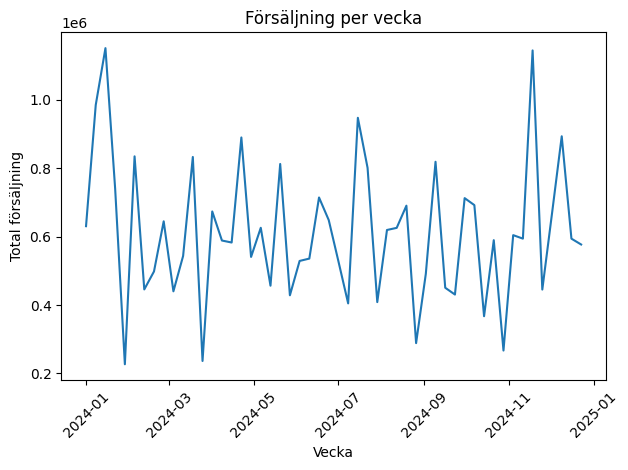

In [258]:
plt.figure()
plt.plot(kpi_forsaljning_vecka["vecka"], kpi_forsaljning_vecka["pris"])
plt.title("Försäljning per vecka")
plt.xlabel("Vecka")
plt.ylabel("Total försäljning")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Tolkning: 

Grafen visar hur försäljningen varierar över tid per vecka.

---

### KPI 2: Avbokningsfrekvens

Beräkning:

In [259]:
avbokningsfrekvens = df["ar_avbokad"].mean() * 100
print(f"Avbokningsfrekvens: {avbokningsfrekvens:.2f}%")

Avbokningsfrekvens: 8.25%


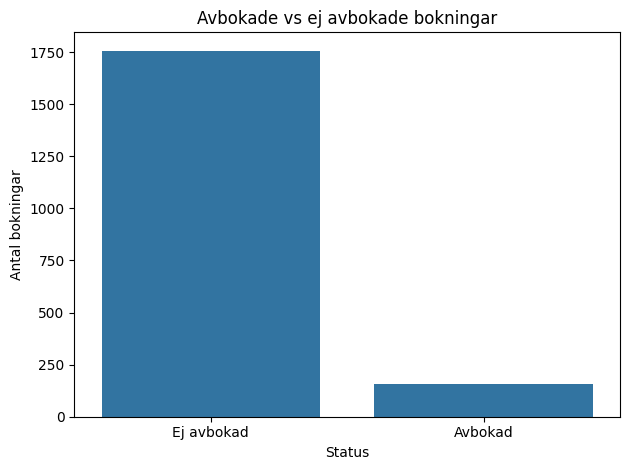

In [262]:
avbokningar["status_text"] = avbokningar["ar_avbokad"].map({True: "Avbokad", False: "Ej avbokad"})

plt.figure()
sns.barplot(data=avbokningar, x="status_text", y="antal")
plt.title("Avbokade vs ej avbokade bokningar")
plt.xlabel("Status")
plt.ylabel("Antal bokningar")
plt.tight_layout()
plt.show()


Tolkning:

Avbokningsfrekvensen visar hur stor andel av bokningarna som inte genomförs. En hög frekvens kan indikera problem med bokningsvillkor, prisnivåer eller kundförväntningar.

---

### KPI 3: Genomsnittligt ordervärde (AOV)

Beräkning:

In [263]:
aov = df_ok["pris"].mean()
print(f"Genomsnittligt ordervärde (AOV): {aov:.2f}")


Genomsnittligt ordervärde (AOV): 18264.03


per pakettyp:

In [264]:
aov_paket = (
    df_ok.groupby("pakettyp")["pris"]
    .mean()
    .reset_index()
    .sort_values("pris", ascending=False)
)


Visualisering:

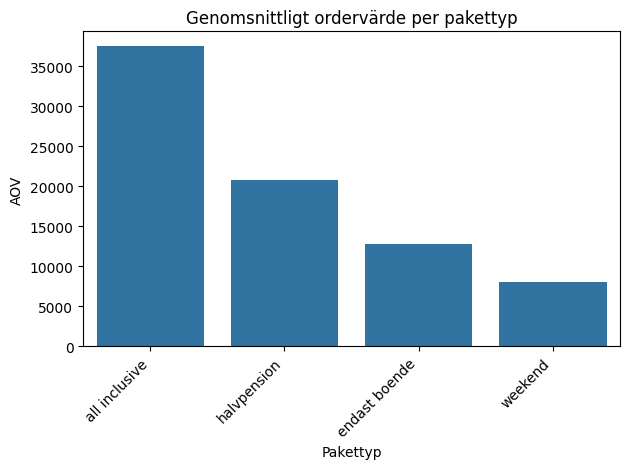

In [265]:
plt.figure()
sns.barplot(data=aov_paket, x="pakettyp", y="pris")
plt.title("Genomsnittligt ordervärde per pakettyp")
plt.xlabel("Pakettyp")
plt.ylabel("AOV")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Tolkning:

KPI:n visar hur mycket en genomsnittlig kund spenderar per bokning. Skillnader mellan pakettyper kan användas för att identifiera vilka produkter som genererar högst värde.

--- 

### KPI 4️: Kundnöjdhet (sentiment)

Beräkning:

In [268]:
sentiment_fordelning = df["sentiment"].value_counts().reset_index()
sentiment_fordelning.columns = ["sentiment", "antal"]

display(sentiment_fordelning)


,sentiment,antal
0,positiv,513
1,neutral,113
2,negativ,55


Visualisering:

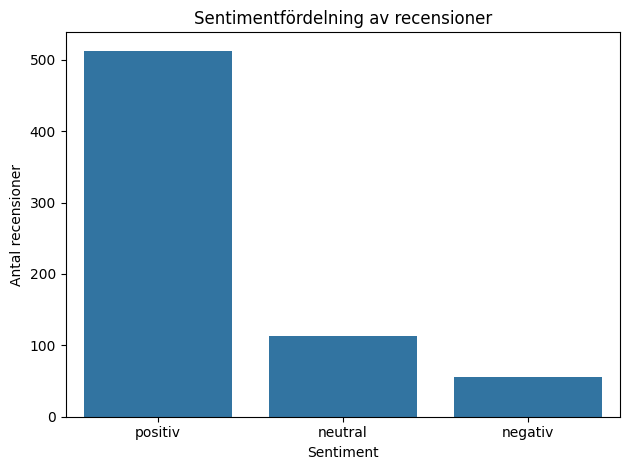

In [269]:
plt.figure()
sns.barplot(
    data=sentiment_fordelning,
    x="sentiment",
    y="antal"
)
plt.title("Sentimentfördelning av recensioner")
plt.xlabel("Sentiment")
plt.ylabel("Antal recensioner")
plt.tight_layout()
plt.show()


Tolkning:

Grafen visar fördelningen av positiva, neutrala och negativa recensioner. En hög andel positiva recensioner indikerar god kundnöjdhet, medan negativa recensioner kan användas för att identifiera förbättringsområden.